### Stable Diffusion 설치

In [1]:
# !pip install -qq diffusers==0.31

### 메모리 부족 시 실행

In [2]:
# torch.cuda.empty_cache()


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so
/opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 113
CUDA SETUP: Loading binary /opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so...


/opt/conda/lib/python3.9/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/nvidia/lib')}
  warn(msg)
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /usr/local/nvidia/lib:/usr/local/nvidia/lib64 did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//10.88.0.1'

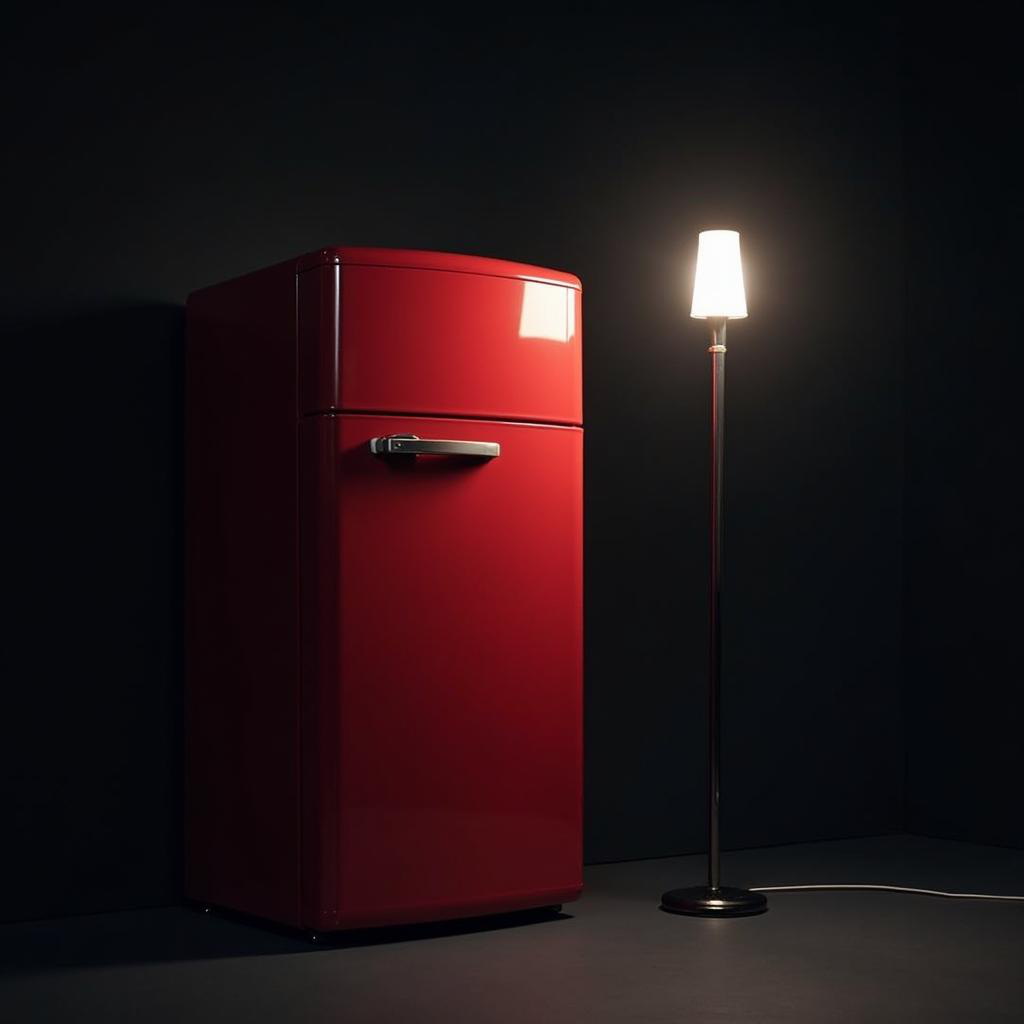

In [3]:
import torch
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image 
from controlnet_aux import OpenposeDetector
from PIL import Image
import cv2
import numpy as np
import os
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler  



# 이미지 불러오기
# canny image로 사용할 이미지
c_image = Image.open(os.path.expanduser("~/aiffel/workspace/image.jpg"))
c_image

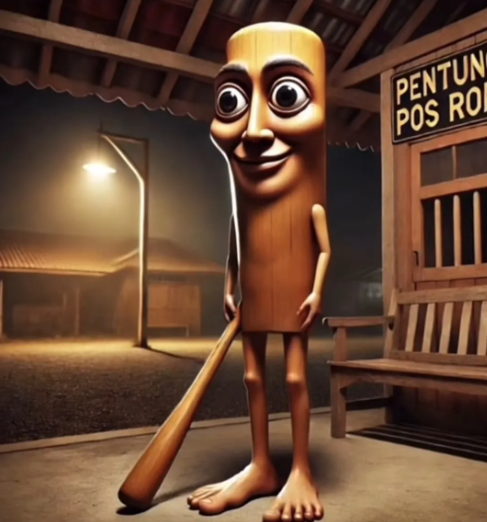

In [4]:
# openpose용 이미지

o_image = Image.open(os.path.expanduser("~/aiffel/workspace/tung.png"))
o_image

In [5]:
canny_image = c_image
canny_image = canny_image.resize((768, 768))

# threshhold를 지정합니다. 
low_threshold = 100
high_threshold = 200

# 이미지를 NumPy 배열로 변환합니다. 
canny_image = np.array(canny_image)

# 인체 감지 포즈를 넣어줄 가운데 부분을 지워줍니다. 
zero_start = canny_image.shape[1] // 4
zero_end = zero_start + canny_image.shape[1] // 2
canny_image[:, zero_start:zero_end] = 0

# 윤곽선을 검출하고 NumPy 배열을 PIL 이미지로 변환합니다. 
canny_image = cv2.Canny(canny_image, low_threshold, high_threshold)
canny_image = canny_image[:, :, None]
canny_image = np.concatenate([canny_image, canny_image, canny_image], axis=2)
canny_image = Image.fromarray(canny_image)
canny_image

cuda


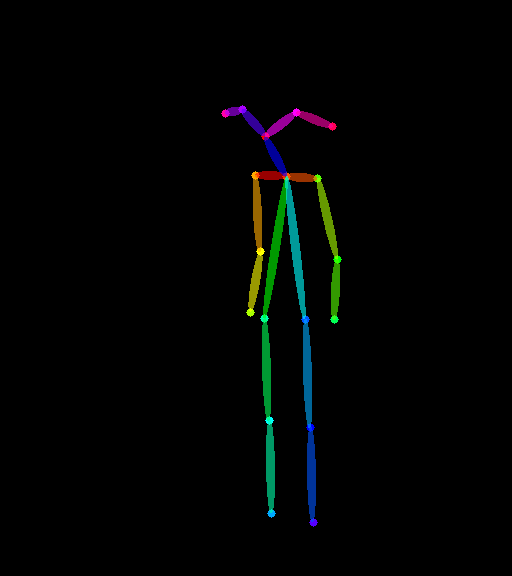

In [6]:
# 자세 검출 확인 (OpenposeDetector)
openpose_image = o_image

openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")
openpose_image = openpose(openpose_image)
openpose_image

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

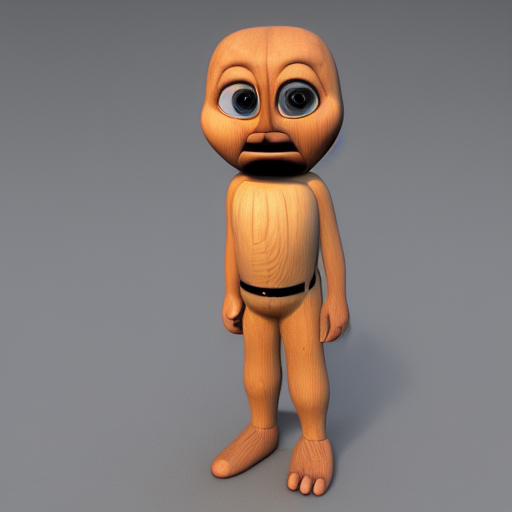

In [7]:
controlnets = [
    ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16),
    ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
]

# 리스트 controlnets를 파이프라인으로 전달
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnets,
    torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# 프롬프트
prompt = "piece of wooden fillar holding baseball bat, 3d rendered, barely smile, big foot"
negative_prompt = "blurry, low quality, noisy, distorted"

# seed 지정(같은 세팅에 같은 시드 == 같은 결과물)
generator = torch.manual_seed(15)

# 이미지 크기를 통일합니다 (512x512로 조정)
openpose_image = openpose_image.resize((512, 512))
canny_image = canny_image.resize((512, 512))

images = [openpose_image, canny_image]

# 이미지 생성
image = pipe(
    prompt=prompt,
    image=images,
    negative_prompt=negative_prompt,
    generator=generator,
    num_inference_steps=10,
    controlnet_conditioning_scale=[0.5, 0.5]
).images[0]

# controlnet_conditioning_scale을 낮출수록 이미지가 특이하게 출력됨(OpenPose, Canny의 가이드를 덜 따르게 됨)

# 이미지 출력
image

### 회고
- 마음에 드는 포즈의 사진을 찾기가 쉽지 않았음
- 프롬프트가 이미지에 잘 반영이 되지 않았음(생각같지 않았음)
- 메모리 초과 이슈로 문제가 많았는데, 스텝을 10으로 낮추고 해결하였음
- 생성용 코드를 실행하기 위해서는 로컬 세팅이 중요할 것 같음